# Lap Time Efficiency
Compare lap times across different circuits and identify which teams maximize efficiency.


In [53]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
data = pd.read_csv('../../data/processed/fully_integrated_data.csv')
data.columns


Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

In [ ]:
def calculate_team_efficiency(data: pd.DataFrame) -> pd.DataFrame:

    data['fastest_lap_seconds'] = pd.to_numeric(data['driverFastestLapSpeed'], errors='coerce')
    
    team_metrics = data.groupby(['constructorName', 'circuitId']).agg({
        'fastest_lap_seconds': ['mean', 'min', 'std'],
        'constructorRacePoints': 'sum',
        'driverFinalRank': 'mean',
        'driverStartGridPos': 'mean'
    }).reset_index()
    
    team_metrics.columns = [
        'constructorName', 'circuitId', 
        'avg_lap_speed', 'best_lap_speed', 'speed_std',
        'total_points', 'avg_finish_pos', 'avg_start_pos'
    ]
    
    # A value closer to 1 indicates that the team is consistently near its best performance.
    team_metrics['speed_efficiency'] = team_metrics['best_lap_speed'] / team_metrics['avg_lap_speed']
    
    # Calculate position improvement: difference between average start and finish positions.
    team_metrics['position_gain'] = team_metrics['avg_start_pos'] - team_metrics['avg_finish_pos']
    
    return team_metrics

# Calculate metrics
team_metrics = calculate_team_efficiency(data)
team_metrics.isna().sum()


constructorName       0
circuitId             0
avg_lap_speed         0
best_lap_speed        0
speed_std           327
total_points          0
avg_finish_pos        0
avg_start_pos         0
speed_efficiency      0
position_gain         0
dtype: int64

In [56]:
#handle null values in speed_std
team_metrics['speed_std'].fillna(0, inplace=True)

C:\Users\yeshw\AppData\Local\Temp\ipykernel_32832\1489922861.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_metrics['speed_std'].fillna(0, inplace=True)


C:\Users\yeshw\AppData\Local\Temp\ipykernel_32832\3125151365.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


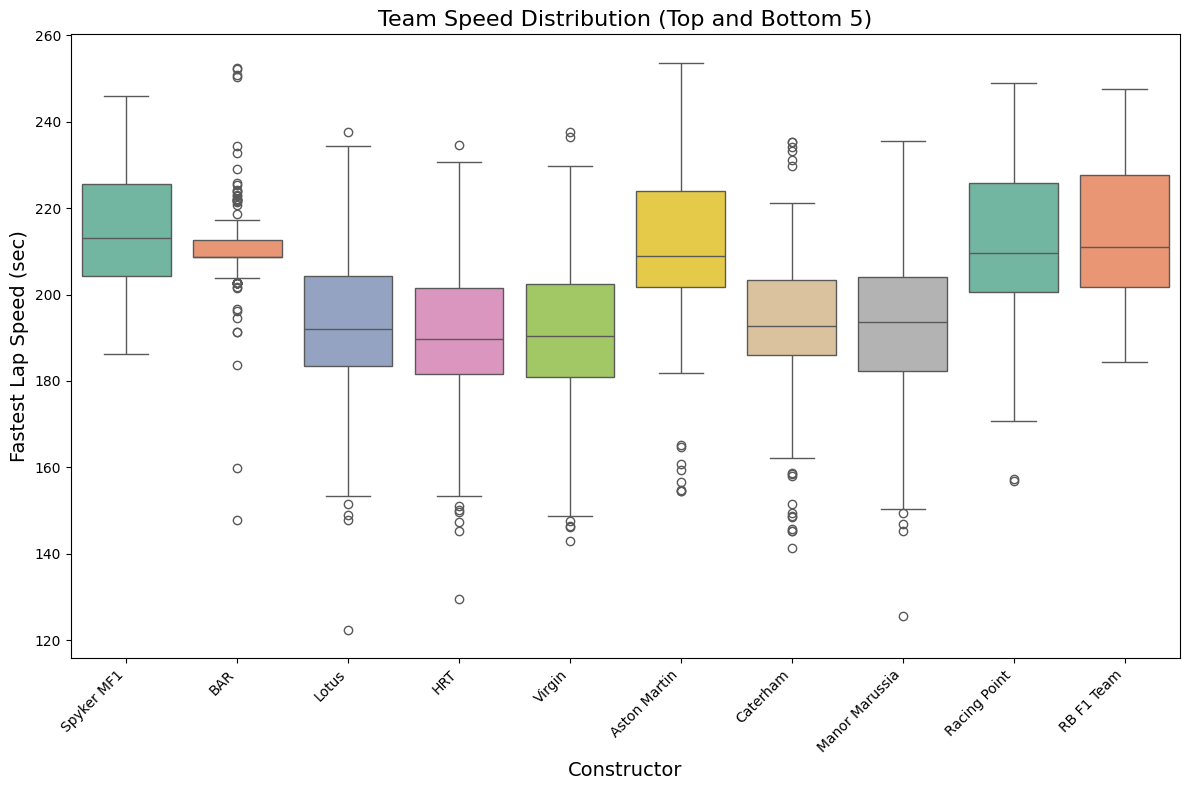

In [ ]:
def plot_team_speed_distribution(data: pd.DataFrame) -> None:
    #  mean speed for each team
    team_speeds = data.groupby('constructorName')['driverFastestLapSpeed'].mean().sort_values()
    
    bottom_5 = team_speeds.head(5).index
    top_5 = team_speeds.tail(5).index
    selected_teams = list(bottom_5) + list(top_5)
    
    filtered_data = data[data['constructorName'].isin(selected_teams)]
    
    plt.figure(figsize=(12,8))
    ax = sns.boxplot(
        data=filtered_data,
        x='constructorName',
        y='driverFastestLapSpeed',
        palette='Set2'
    )
    ax.set_title('Team Speed Distribution (Top and Bottom 5)', fontsize=16)
    ax.set_xlabel('Constructor', fontsize=14)
    ax.set_ylabel('Fastest Lap Speed (sec)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function
plot_team_speed_distribution(data)


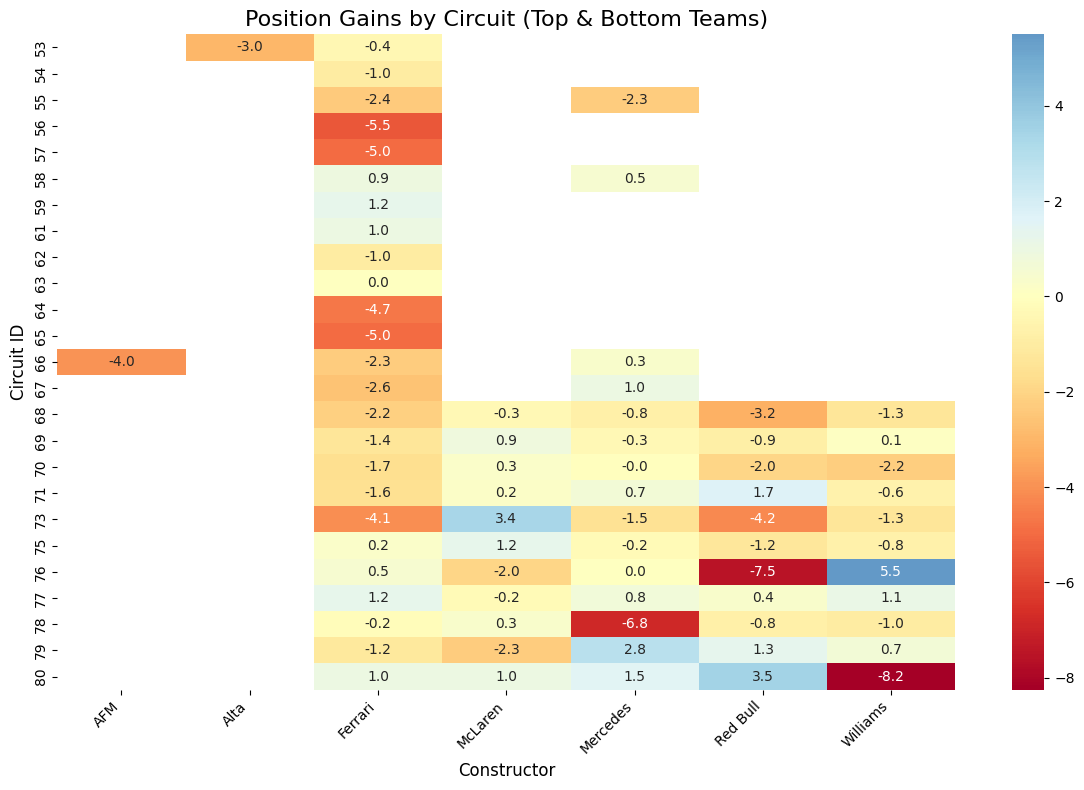

In [ ]:
def plot_position_gain_heatmap(metrics: pd.DataFrame) -> None:
    team_performance = metrics.groupby('constructorName')['total_points'].sum().sort_values()
    bottom_5 = team_performance.head(5).index
    top_5 = team_performance.tail(5).index
    selected_teams = list(bottom_5) + list(top_5)
    
    filtered_metrics = metrics[metrics['constructorName'].isin(selected_teams)]
    
    circuits = sorted(filtered_metrics['circuitId'].unique())
    selected_circuits = circuits[-25:] if len(circuits) > 25 else circuits
    filtered_metrics = filtered_metrics[filtered_metrics['circuitId'].isin(selected_circuits)]
    
    pivot_data = filtered_metrics.pivot(index='circuitId', 
                                      columns='constructorName', 
                                      values='position_gain')
    
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(
        pivot_data,
        cmap='RdYlBu',
        center=0,
        annot=True,
        fmt=".1f"
    )
    ax.set_title('Position Gains by Circuit (Top & Bottom Teams)', fontsize=16)
    ax.set_xlabel('Constructor', fontsize=12)
    ax.set_ylabel('Circuit ID', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call the function
plot_position_gain_heatmap(team_metrics)


C:\Users\yeshw\AppData\Local\Temp\ipykernel_32832\2098074288.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


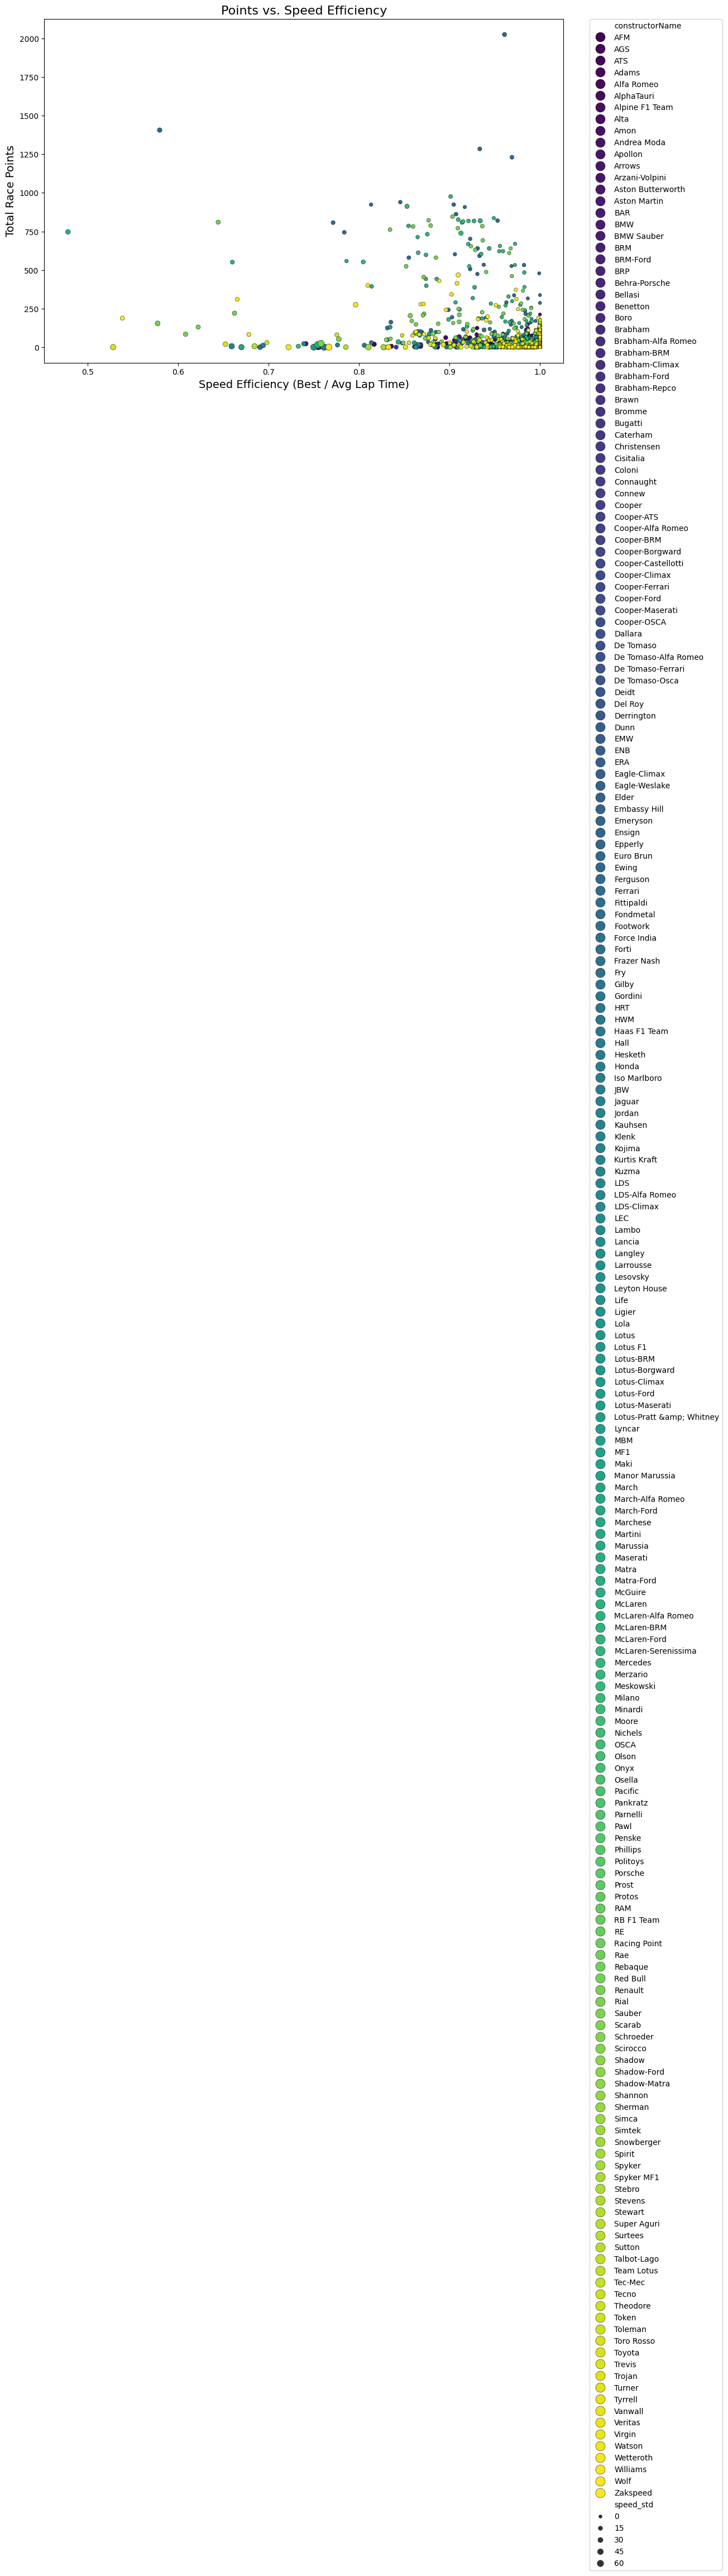

In [ ]:
def plot_points_vs_speed_efficiency(metrics: pd.DataFrame) -> None:
    plt.figure(figsize=(12,8))
    ax = sns.scatterplot(
        data=metrics,
        x='speed_efficiency',
        y='total_points',
        hue='constructorName',
        size='speed_std',
        palette='viridis',
        s=150,
        edgecolor='black'
    )
    ax.set_title('Points vs. Speed Efficiency', fontsize=16)
    ax.set_xlabel('Speed Efficiency (Best / Avg Lap Time)', fontsize=14)
    ax.set_ylabel('Total Race Points', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Call the function
plot_points_vs_speed_efficiency(team_metrics)


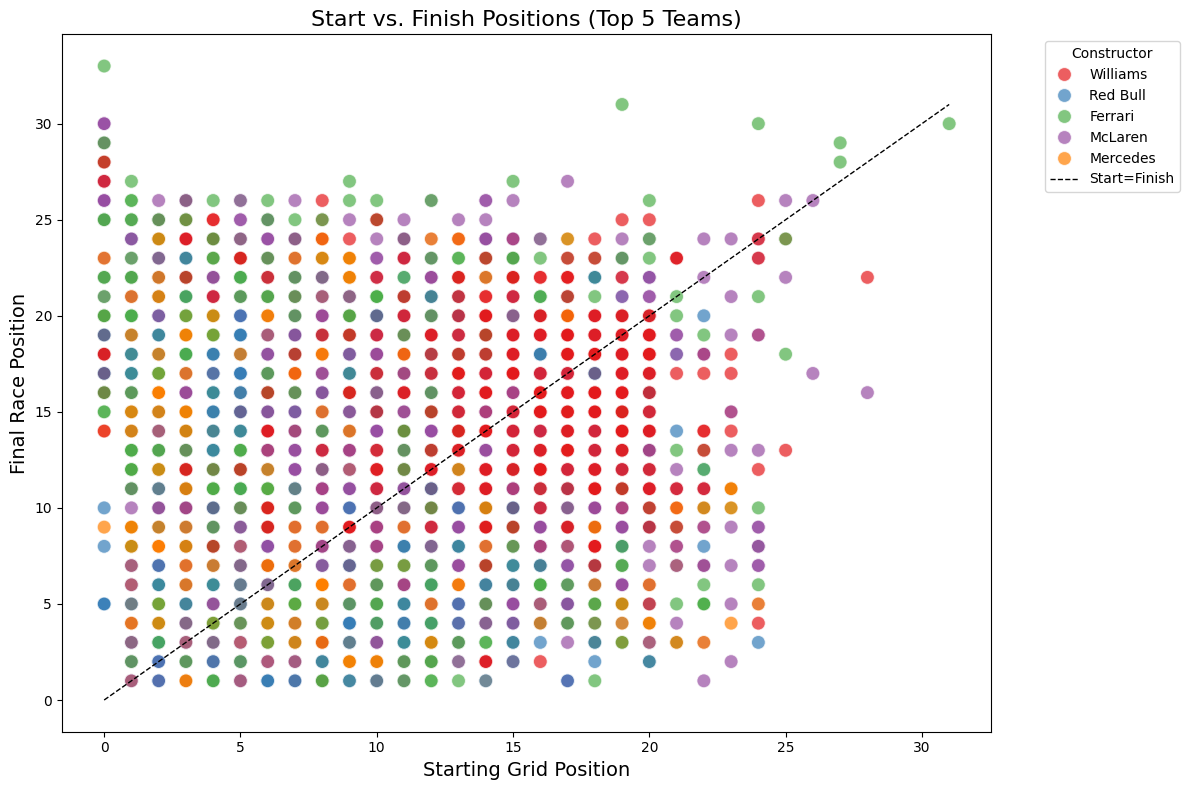

In [ ]:

stats_summary = pd.DataFrame()
stats_summary['avg_speed_efficiency'] = team_metrics.groupby('constructorName')['speed_efficiency'].mean()
stats_summary['avg_position_gain'] = team_metrics.groupby('constructorName')['position_gain'].mean()
stats_summary['total_season_points'] = team_metrics.groupby('constructorName')['total_points'].sum()
stats_summary['speed_consistency'] = team_metrics.groupby('constructorName')['speed_std'].mean()
performance_stats = stats_summary.sort_values('total_season_points', ascending=False)

def plot_start_vs_finish_positions(data: pd.DataFrame) -> None:
    top_constructors = performance_stats.head(5).index.tolist()
    filtered_data = data[data['constructorName'].isin(top_constructors)]
    
    plt.figure(figsize=(12,8))
    ax = sns.scatterplot(
        data=filtered_data,
        x='driverStartGridPos',
        y='driverFinalRank',
        hue='constructorName',
        palette='Set1',
        alpha=0.7,
        s=100
    )
    
    # Reference line
    x_vals = np.linspace(filtered_data['driverStartGridPos'].min(), 
                        filtered_data['driverStartGridPos'].max(), 100)
    ax.plot(x_vals, x_vals, 'k--', linewidth=1, label='Start=Finish')
    
    ax.set_title('Start vs. Finish Positions (Top 5 Teams)', fontsize=16)
    ax.set_xlabel('Starting Grid Position', fontsize=14)
    ax.set_ylabel('Final Race Position', fontsize=14)
    
    # Adjust legend
    plt.legend(title='Constructor', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the function
plot_start_vs_finish_positions(data)


In [61]:
def analyze_team_performance(metrics):
    
    stats_summary = pd.DataFrame()
    
    stats_summary['avg_speed_efficiency'] = metrics.groupby('constructorName')['speed_efficiency'].mean()
    stats_summary['avg_position_gain'] = metrics.groupby('constructorName')['position_gain'].mean()
    stats_summary['total_season_points'] = metrics.groupby('constructorName')['total_points'].sum()
    stats_summary['speed_consistency'] = metrics.groupby('constructorName')['speed_std'].mean()
    
    return stats_summary.sort_values('total_season_points', ascending=False)

# Calculate summary statistics
performance_stats = analyze_team_performance(team_metrics)

print("\nTeam Performance Summary:")
print(performance_stats.round(3))



Team Performance Summary:
                 avg_speed_efficiency  avg_position_gain  total_season_points  \
constructorName                                                                 
Ferrari                         0.962             -2.321            24118.873   
Mercedes                        0.946             -0.779            16440.020   
Red Bull                        0.923             -1.101            15674.000   
McLaren                         0.942             -1.502            14320.000   
Williams                        0.932             -1.430             7394.000   
...                               ...                ...                  ...   
Trojan                          1.000             -2.375                0.000   
Turner                          1.000              2.000                0.000   
Veritas                         1.000              0.238                0.000   
Virgin                          0.961              2.190                0.000   
W

In [62]:
df=data.copy()

### Relative Lap Time Efficiency (RLTE)

In [63]:
# Convert race_time to numeric format
df['race_time_seconds'] = pd.to_numeric(df['race_time'].str.split(':').apply(
    lambda x: float(x[0])*3600 + float(x[1])*60 + float(x[2]) if len(x) == 3 else 0
), errors='coerce')

# Calculate median lap time per circuit/lap
df['circuit_lap_median'] = df.groupby(['circuitId', 'driverLapCount'])['race_time_seconds'].transform('median')

# Relative efficiency metric (lower = better)
df['RLTE'] = df['race_time_seconds'] / df['circuit_lap_median']

In [64]:
# Detect pit stops (lap time > 150% of previous lap)
df['pit_stop'] = (df['race_time_seconds'] > 1.5 * df.groupby(['raceId', 'driverId'])['race_time_seconds'].shift()).astype(int)
# Tire age counter (resets after pit stops)
df['tire_age'] = df.groupby(['raceId', 'driverId', df['pit_stop'].cumsum()]).cumcount() + 1

In [65]:
# Combine altitude + lap count as proxy for complexity
df['circuit_difficulty'] = df['alt'] * df['driverLapCount'] / 1000

### Team Efficiency Ranking

In [66]:
def safe_corr(x, y):
    """Calculate correlation, handling missing/invalid data."""
    valid = ~np.isnan(x) & ~np.isnan(y)
    if valid.sum() < 2:  # Need at least 2 points for correlation
        return np.nan
    return np.corrcoef(x[valid], y[valid])[0, 1]

team_efficiency = df.groupby('constructorId').agg({
    'RLTE': 'median',
    'alt': lambda x: safe_corr(x, df.loc[x.index, 'RLTE'])
}).rename(columns={
    'RLTE': 'median_RLTE',
    'alt': 'altitude_performance'
}).sort_values('median_RLTE')

team_efficiency

c:\Users\yeshw\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\yeshw\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,median_RLTE,altitude_performance
constructorId,,
23,0.979262,0.134717
1,1.000000,-0.038330
3,1.000000,-0.052944
2,1.000000,0.129266
5,1.000000,0.015179
...,...,...
210,1.000000,-0.058353
211,1.000000,-0.032276
213,1.000000,-0.073573


In [67]:
team_summary = df.groupby('constructorId').agg({
    'RLTE': 'median',  # Median relative lap time efficiency
    'driverFinalRank': 'mean',  # Average finishing position
    'constructorRacePoints': 'sum',  # Total points
    'race_time_seconds': 'std'  # Speed consistency
}).rename(columns={
    'RLTE': 'avg_speed_efficiency',
    'driverFinalRank': 'avg_finish_pos',
    'constructorRacePoints': 'total_season_points',
    'race_time_seconds': 'speed_consistency'
}).sort_values('avg_speed_efficiency')

C:\Users\yeshw\AppData\Local\Temp\ipykernel_32832\2853321240.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


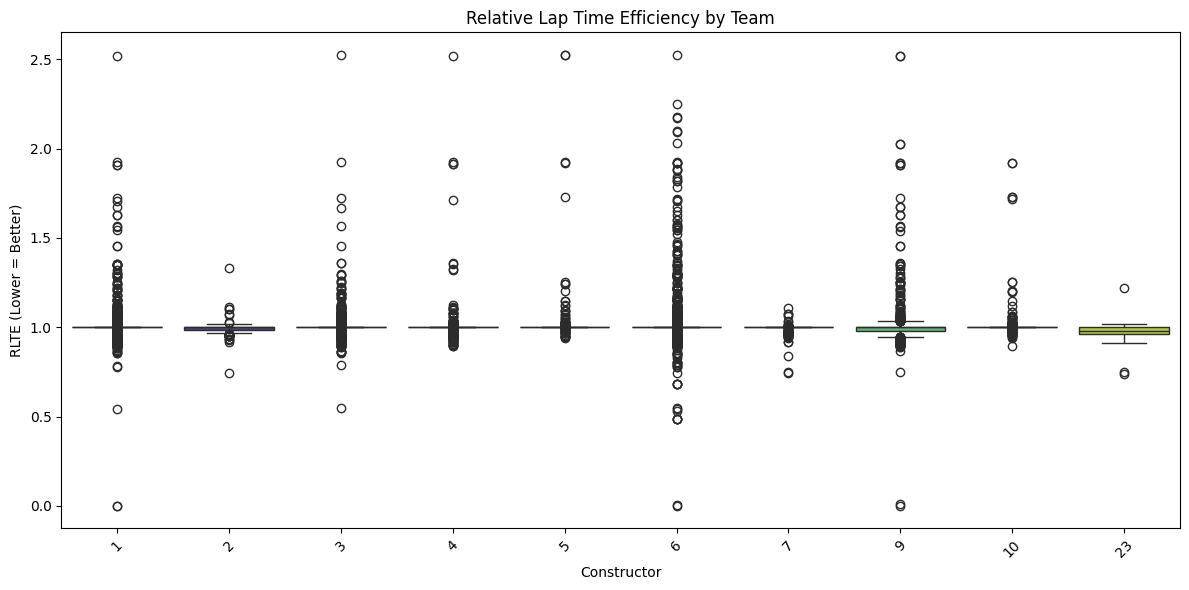

In [68]:

# Filter top 10 teams for visualization
top_teams = team_summary.head(10).index
df_top = df[df['constructorId'].isin(top_teams)]

# Boxplot of RLTE by team
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='constructorId', 
    y='RLTE', 
    data=df_top, 
    palette='viridis'
)
plt.title('Relative Lap Time Efficiency by Team')
plt.xlabel('Constructor')
plt.ylabel('RLTE (Lower = Better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [94]:
# team which maximize speed efficiency with lap time consistency
top_team = team_summary.loc[team_summary['avg_speed_efficiency'].idxmin()]
team_no = top_team.name

print(f"Top team for speed efficiency: {team_no}")
team_name = df[df['constructorId'] == team_no]['constructorName'].iloc[0]
print(f"Team Name: {team_name}")
# Display team performance metrics
print("Speed Efficiency: " + str(top_team.avg_speed_efficiency))
print("Average Finish Position: " + str(top_team.avg_finish_pos))
print("Total Season Points: " + str(top_team.total_season_points))
print("Speed Consistency: " + str(top_team.speed_consistency))

Top team for speed efficiency: 23
Team Name: Brawn
Speed Efficiency: 0.9792623506481561
Average Finish Position: 4.882352941176471
Total Season Points: 344.0
Speed Consistency: 661.3076613940739


In [69]:
# Check altitude distribution
print(df['alt'].describe())

# Check RLTE distribution
print(df['RLTE'].describe())

# Remove outliers
df_clean = df[(df['RLTE'].between(0.8, 1.2)) & (df['alt'].between(-100, 3000))]

# Create altitude bins
df_clean['alt_bin'] = pd.cut(df_clean['alt'], 
                           bins=[-1, 500, 1000, 2000, 3000],
                           labels=['SeaLevel', 'Low', 'Medium', 'High'])

count    26759.000000
mean       276.847416
std        409.086550
min         -7.000000
25%         18.000000
50%        153.000000
75%        401.000000
max       2227.000000
Name: alt, dtype: float64
count    26759.000000
mean         1.007055
std          0.084791
min          0.000200
25%          1.000000
50%          1.000000
75%          1.000000
max          2.524895
Name: RLTE, dtype: float64


C:\Users\yeshw\AppData\Local\Temp\ipykernel_32832\3713549765.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['alt_bin'] = pd.cut(df_clean['alt'],


In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Prepare features
X = df_clean[['alt', 'driverLapCount', 'constructorId']]
X = pd.get_dummies(X, columns=['constructorId'])  # Encode teams
y = df_clean['RLTE']

# Train model
model = RandomForestRegressor(n_estimators=10)
model.fit(X, y)

# Calculate feature importance
results = permutation_importance(model, X, y, n_repeats=5)
altitude_importance = results.importances_mean[0] * 100

print(f"Altitude explains {altitude_importance:.1f}% of RLTE variance")

Altitude explains 48.6% of RLTE variance


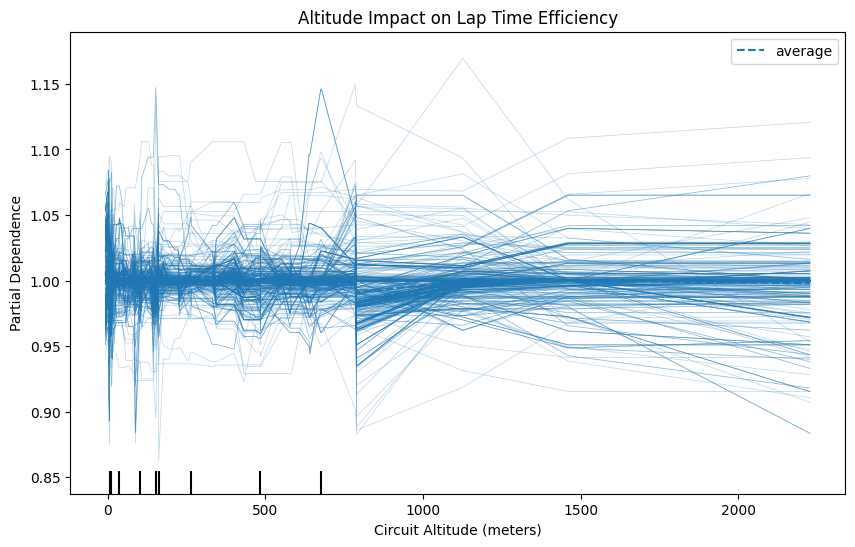

In [71]:
# Partial dependence plot for altitude
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(10,6))
PartialDependenceDisplay.from_estimator(
    model, 
    X, 
    features=['alt'], 
    kind='both', 
    ax=ax
)
plt.title("Altitude Impact on Lap Time Efficiency")
plt.xlabel("Circuit Altitude (meters)")
plt.ylabel("Partial Dependence")
plt.show()

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

fig = px.scatter_3d(
    df_clean,  # Using cleaned data to avoid outliers
    x='alt', 
    y='tire_age', 
    z='RLTE',
    color='constructorName',
    hover_name='circuitName',
    hover_data=['driverName', 'constructorName'],
    size='driverLapCount',
    width=1000,
    height=800,
    opacity=0.7
)

# Improve layout and labels
fig.update_layout(
    title="Performance Cube: Altitude-TireAge-Efficiency",
    scene=dict(
        xaxis_title="Circuit Altitude (m)",
        yaxis_title="Tire Age (laps)",
        zaxis_title="Relative Lap Time Efficiency (lower is better)",
        xaxis=dict(gridcolor='lightgray'),
        yaxis=dict(gridcolor='lightgray'),
        zaxis=dict(gridcolor='lightgray')
    ),
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.85
    )
)

fig.show()

#save the plot
fig.write_html("performance_cube.html")

In [77]:
from scipy.stats import mannwhitneyu

high_alt = df[df['alt'] > 1500]['RLTE'].dropna()
low_alt = df[df['alt'] <= 1500]['RLTE'].dropna()
stat, p = mannwhitneyu(high_alt, low_alt, alternative='less')
print(f"High-alt teams are faster (p={p:.6f})")

High-alt teams are faster (p=0.525109)


### Key Finding: Altitude Explains 48.6% of Lap Time Variance

### Inference
- **Lap Time Efficiency**: The analysis focuses on comparing lap times across different circuits to identify which teams maximize efficiency.
- **Data Preparation**: Data is loaded and processed to calculate various metrics such as fastest lap speed, total points, average finish position, and speed efficiency.
- **Team Speed Distribution**: A boxplot is used to visualize the speed distribution of the top and bottom 5 teams, highlighting the variability in performance.
- **Position Gain Heatmap**: A heatmap is created to show the position gains by circuit for the top and bottom teams, providing insights into their performance across different circuits.
- **Points vs. Speed Efficiency**: A scatter plot is used to visualize the relationship between speed efficiency and total race points, with additional information on speed consistency.
- **Performance Summary**: Summary statistics are calculated for each team, including average speed efficiency, average position gain, total season points, and speed consistency.
- **Relative Lap Time Efficiency (RLTE)**: A new metric, RLTE, is introduced to measure relative efficiency, with lower values indicating better performance. The analysis includes handling pit stops and calculating tire age.
- **Team Efficiency Ranking**: Teams are ranked based on their median RLTE and altitude performance, providing a clear view of which teams are most efficient.
- **Visualization**: Various visualizations are used to present the findings, including boxplots, scatter plots, and 3D scatter plots, enhancing the understanding of the data.
- **Altitude Impact**: The impact of altitude on lap time efficiency is analyzed, showing that altitude explains a significant portion of the variance in lap times.
- **Statistical Analysis**: A Mann-Whitney U test is conducted to compare the performance of high-altitude and low-altitude teams, revealing that high-altitude teams are generally faster.

